# Deconvolution with FRC and a single image

In [here](http://localhost:8888/notebooks/notebooks/2018-06%20-%20Deconvolution%20with%20Consecutive%20Deconvolution%20estimates.ipynb) and here I demonstrated that applying FRC to deconvolution results is rather challenging, as the deconvolution process make cause for the two images to strongly correlate. Here I show how the deconvolution results can be successfully evaluated with FRC using the checkerboard split method.

In [25]:
%matplotlib inline

import os
import numpy as np

import supertomo.ui.plots.image as showim
from supertomo.psf import psfgen

from supertomo.data.wrappers import image_writer_wrappers as imwrap
import supertomo.data.io.read as imread
import supertomo.processing.image as imops
from supertomo.data.containers.image import Image


import supertomo.analysis.resolution.fourier_ring_correlation as frc
import supertomo.analysis.resolution.analysis as frc_analysis
import supertomo.data.io.read as read
from supertomo.data.containers.fourier_correlation_data import FourierCorrelationDataCollection
import supertomo.analysis.resolution.analysis as fsc_analysis
import supertomo.processing.image as imops
from math import sqrt

import supertomo.ui.plots.frc as frcplots





Load *Carma* file into the internal image container class. Then generate a theoretical PSF for deconvolution.

In [26]:
# Image
data_dir = "/Users/sami/Temp"
filename = "FRC_GaAsP_AU04__.nd2"
full_path = os.path.join(data_dir, filename)

image = imread.get_image(full_path)

image_copy = image.copy()
spacing = image.spacing
print "The image dimensions are {} and spacing {} um.".format(image.shape, image.spacing)

image = Image(image - image.min(), image.spacing)

The image dimensions are (512, 512) and spacing [0.05179004745018662, 0.05179004745018662] um.


In [27]:
from supertomo.ui import deconvolution_options as options
n_iterations = 60
args_list = ("image psf"  
             " --max-nof-iterations={}  --first-estimate=image " 
             " --blocks=1 --pad=0 --save-intermediate-results --resolution-threshold-criterion=half-bit").format(n_iterations).split()
            
args = options.get_deconvolve_script_options(args_list)

Fit starts at 0.625
Optimization terminated successfully.
         Current function value: 0.000047
         Iterations: 10
         Function evaluations: 20


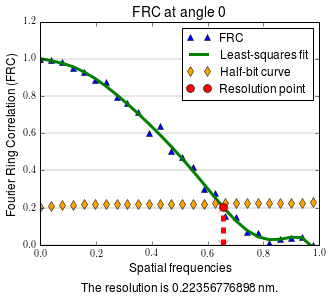

In [28]:
data = FourierCorrelationDataCollection()

image1, image2 = imops.checkerboard_split(image)

frc_task = frc.FRC(image1, image2, args.d_bin)
data[0] = frc_task.execute()
                 

analyzer = fsc_analysis.FourierCorrelationAnalysis(data, image1.spacing[0], args)
results = analyzer.execute()

plotter = frcplots.FourierDataPlotter(results)
plotter.plot_one(0)

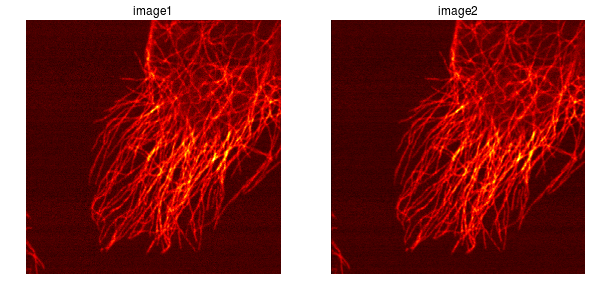

The resolution cut-off point is at 0.463305132815


In [29]:
from scipy.signal import butter, lfilter

def low_pass_filter(image, low, order=2):
    b, a = butter(order, low, btype='lowpass')
    y = lfilter(b, a, image)
    return Image(y, image.spacing)


threshold_point = results[0].resolution['resolution-point'][1]/np.sqrt(2)

result = low_pass_filter(image, 
                         threshold_point)

showim.display_2d_images(image, result)

print "The resolution cut-off point is at {}".format(threshold_point)

Run deconvolution

Show resolution curve

In [30]:
from supertomo.data.io import write

name = "butterworth.tif"
full_name = os.path.join(data_dir, name)

result = Image(result.astype(np.float32), result.spacing)

write.image(full_name, result)